# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**
1. Firstly, the smartcab does not move around the the environment at all. It simply remains stationary at the spot in which it was spawned.
1. Secondly, the rewards received vary depending on the state of the smartcab's local environment. In this case, local enviroment refers to the intersection(s) in the immediate vicinity of the smartcab.
 - 'Agent idled at a red light'. If the smartcab is facing a red light, the agent receives positive rewards for not moving, with the value increasing as time passes. However, if an opportunity to safely make a right-turn (with no traffic coming from the agent's left) is possible, the reward for remaining stationary appears to decrease somewhat.
 - 'There was a green light with no oncoming traffic'. If the smartcab is facing a green light and fails to move (when safe to do so), the rewards received have strongly negative values presumably because this is a serious traffic violation. The rewards appear to decrease rapidly to very negative values the longer the agent remains still in the presence of a green light.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**
1. *`agent.py`* Part 1. This question is a bit ambiguous. There are many flags that control behaviour in *`agent.py`*, so I will mention a few that control the agent itself, and a few that control the simulation. The following three flags exist that control the agent's behaviour:
 - **learning**: A boolean value that toggles whether the agent will perform learning from Q-Learning or not. Set to *True* if learning is enabled for the agent.
 - **epsilon**: This real value controls the exploration factor used in Q-Learning.
 - **alpha**: This real value controls the learning rate used in Q-Learning.
1. *`agent.py`* Part 2. The following three flags control behaviour in the simulation:
 - **enforce_deadline**: This flag indicates whether the simualted environment will penalise the agent for failing to reach the destination before the time expires.
 - **log_metrics**: This flag determines if metrics are captured and logged to a file for later use in producing data visualisations of the agent's performance.
 - **n_test**: This flag controls the number of tests to be run after the agent has been trained using QLearning.
1. In *`environment.py`*, the class function that is called when an agent performs an action is '*act()*'.
1. In *`simulator.py`*, the *render_text()* function outputs text and logging statements to the terminal/command prompt, whereas *render()* draws the various graphical elements such as the traffic grid, the smartcab, dummy agents, traffic lights as well as the textual information regarding the smartcab's state, rewards and current enviroment.
1. In *`planner.py`*, the *next_waypoint()* function considers the East-West direction first before evaluating the North-South direction.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


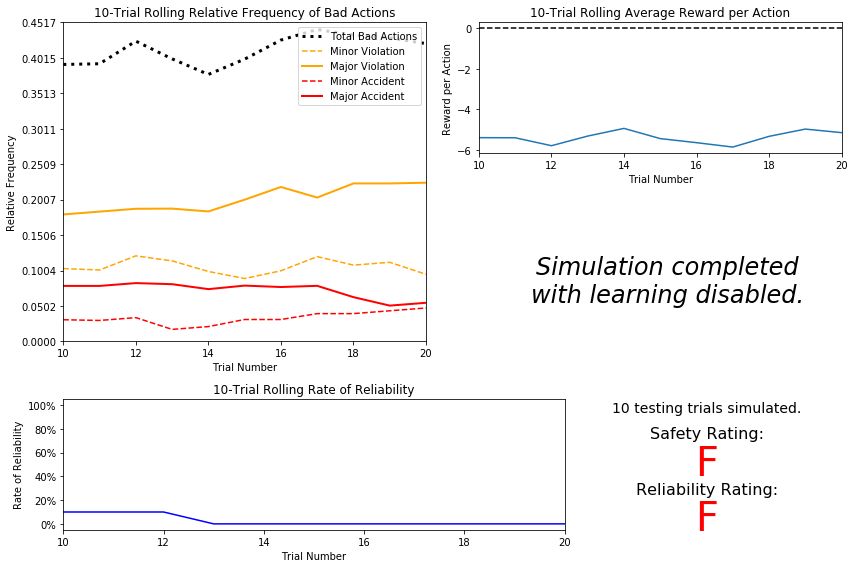

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**
1. First, it can be seen from the output above that learning is disabled for this simulation. Therefore, the agent will not be using any computational intelligence to navigate the environment.
1. The graph displaying the 'frequency of bad actions' shows that the agent is taking bad actions ~40-45% of the time. Major and minor violations occur ~22% and ~12% of the time respectively, and major and minor accidents occur ~8% and 4% of the time respectively. The overall 'bad action' rate indicates that the agent's behaviour is largely random, with traffic violations or accidents occuring about half of the time, as would be expected from the random assignment of choice in the choose_action() function.
1. The agent has received a grade of 'F' for reliability, which makes sense considering that the agent's actions are random and the reliability criteria requires the agent to reach the destination on time in excess of 60% of the time. In order for the agent to reach the destination before time runs out and obtain higher reliability scores, it would need to choose actions that move it in the direction of the destination.
1. The 'rate of reliability' is also fairly constant over all the training trials and exhibits a very low value barely above 0% (or possible even 0%). This makes sense because the agent's choice of action doesn't take into consideration the destination, so the agent is highly unlikely to make it to the destination before time runs out, except by pure chance.
1. As can be seen in the graph for 'average rewards per action', the rewards received by the agent in response to its actions are strongly negative. The environment appears to heavily penalise the agent for it actions. The rewards stay fairly constant over the simulation, and do not increase with time. This indicates that the agent isn't taking actions that increase its rewards. Even if the agent acts in a way that does not result in a violation or an accident, its random choices will likely still cause it to move in a direction away from its destination most of the time, incurring further penalty.
1. As can be seen in all of the graphs, the outcome of the agent's actions yields fairly constant results across all of the training runs for the respective metrics being measured. As the training trials increase over time, there is no discernible trend showing a degradation or improvement in performance. Again, this is as expected for an agent acting randomly.
1. The overall safety and reliability rating for this smartcab agent (as currently programmed) results in a grade of 'F'. If this were a real smartcab, it would be a danger to to its passengers and other road-users, as well as utterly useless in terms of reliability. It displays no awareness or understanding of traffic rules, nor does it have any logic to move it closer to the intended destination.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

The features available to the agent that are relevant for safety are the colour of the traffic light, and the intended direction of travel of oncoming and adjacent vehicles. In terms of reliability, the next waypoint direction and the deadline are relevant features.

The safety features are appropriate choices because they relate to information about the state of other cars in the world, and what direction they are headed in (relative to the agent). In addition to knowledge of other cars' headings and locations, traffic light colour indicates what traffic rules the agent should observe and how to interact with the other vehicles at a given moment in time.

The reliability features are relevant because they relate to information about the location of the final goal relative to the agent's current location. Without knowledge of the goal, the agent cannot know if it is heading in the right direction. Similarly, the deadline information is useful to know how much time is left before the trip expires.

However, not all of these features are neccessary to define the state space of the agent in the environment. The features listed above have the following possible values:

| Feature       | States |
|---------------|--------|
| waypoint      | 3      |
| traffic light | 2      |
| left          | 4      |
| right         | 4      |
| oncoming      | 4      |
| deadline      | ~N where N = length/width of grid   |

The first thing to notice is that although the deadline is relevant to reliability, the large range of values it can represent immediately makes the state space size very large. More importantly, the agent in this particular simulation cannot realistically utilise the deadline information unless it is willing to violate traffic laws in order to take a shortcut to the destination in an effort to reduce the number of steps involved. For this reason, the ```deadline``` feature will not be used.


### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

Following on from the previous question, the selected features are as follows:

| Feature       | States |
|---------------|--------|
| waypoint      | 3      |
| traffic light | 2      |
| left          | 4      |
| right         | 4      |
| oncoming      | 4      |

From the above, the state space can be computed as 3\*2\*4\*4\*4 = 384. With this many states, the agent may not be able to explore all of the state transitions from one state to the next, and be unable to discover the rewards for the many action to choose from, or it would take a very long time to train using a slowly decaying epsilon value. (While working on subsequent questions in this notebook, I found a [post](https://discussions.udacity.com/t/the-smartcab-project-is-kicking-my-ass/222502/4) on the Udacity forums that suggested one can estimate N\*log(N) training trials (aprroximately 992) in order to realistically explore the state space to discover appropriate rewards.)

Clearly, this state space is too large.

#### Feature Space Reduction

If we take into consideration the U.S. traffic laws, we can begin to make some decisions to further reduce the state space based on the utility of the features. The following (simplified) traffic rules apply to most 4-way intersections:
1. If the traffic light facing the vehicle is red, stop.
 1. A right turn at a red light is permitted only if there are no vehicles approaching from the left.
1. If the traffic light facing the vehicle is green, and the intended direction of travel is:
 1. forward, then proceed forward. Any vehicles wishing to turn must yield the right-of-way to you.
 1. left, then yield to oncoming vehicles either travelling forward or making right turns.
 1. right, then yield to oncoming vehicles making left turns.
 
Examining the above rules closer, it can be seen that:
1. Rule 1A implies that when the light is red, the only movement permitted is a right turn **and** only if the left vehicle is None; otherwise don't move. The right and forward headings of other vehicles are irrelevant.
1. Rule 2A implies that when travelling forward, the heading of other vehicles is unimportant; the left, right and oncoming vehicle headings can be ignored.
1. Rule 2B implies that a left turn is possible only if the oncoming vecicle is also turning left.
1. Rule 2C implies that a right turn is possible only if the oncoming vehicle is **not** turning left.

It also follows from the rules above that the feature 'right' (the heading of the vehicle to the right) is not relevant for any rule so we can discard it from consideration. Therefore, the features used can be further reduced to:
 
| Old Feature   	| New Feature      	| States 	| Explanation                                  	|
|---------------	|------------------	|--------	|----------------------------------------------	|
| waypoint      	| waypoint         	| 3      	| Green light: 3 states (left, right, forward) 	|
| waypoint      	| waypoint         	| 2      	| Red light: 2 states (waypoint == right)      	|
| traffic light 	| traffic light    	| 2      	| red, green                                   	|
| left          	| left != forward  	| 2      	| Only applicable to red lights                	|
| right         	| N/A              	| -      	| Discarded                                    	|
| oncoming      	| oncoming == left 	| 2      	| Only applicable to green lights              	|

With the above features in place, the state space is reduced to a total of 10 states (4 possible states when the light is red, 6 possible states when the light is green).

#### Further Reductions
After making further progress with the other questions in this project and reaching the section requiring examination of the state-action results logs from QLearning, further opportunities for state space reductions were identified. For a red light, the state can be more succinctly defined as a single boolean resulting from the conjunction of ```waypoint == 'right' AND left != 'forward'```, thereby reducing the red state combinations from 4 to 2. Similarly, the ```oncoming``` variable is irrelevant for a green light where the agent intends to move forward, so the state space for that case is reduced from 2 combinations to 1. As a result, 3 states are discarded leaving a total of 7 states to be learned.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

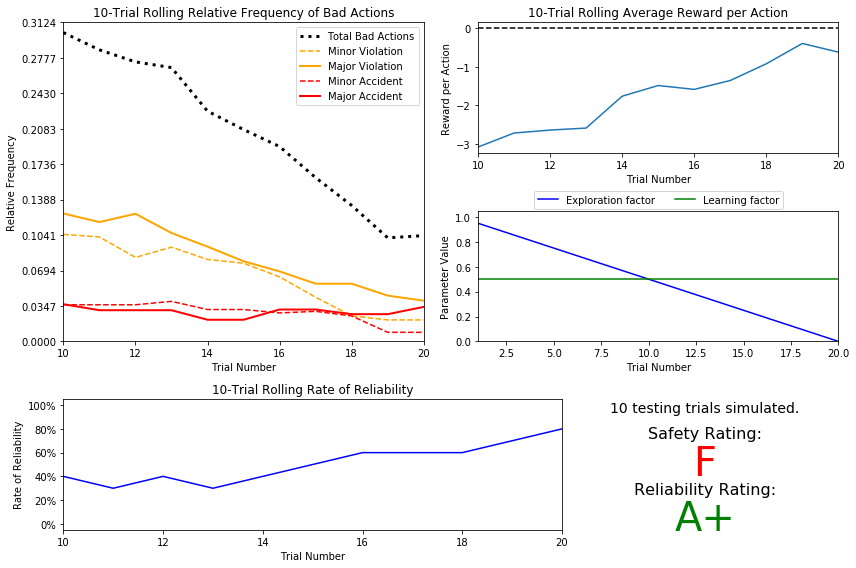

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

1. Comparing the default driving agent with that of the QLearning-enabled agent, it is apparent that the QLearning-enabled agent performs much better in almost all respects.
 - With the exception of the Rate of Reliability graph, all of the metrics are very dissimilar with the default agent's performance. In this particular instance, the reliability rating for this agent is 'D' which is still fairly poor performance. One can see that the overall reliability isn't improving much over time, and in fact it is decreasing towards the end of training trials.
 - With respect to the Frequency of Bad Actions, it can be seen that all types of bad actions are reducing in frequency over time as the number of training trials increases. This is an indication that the agent is learning from its actions. This is also borne out by the Average Reward per Action graph that shows consistently rising rewards received by the agent as learning progresses. 
1. There were 20 training trials conducted before the agent was tested. This makes sense given that the epsilon-tolerance is 0.05 and epsilon starts at a value of 1 and decays at a linear rate, decreasing by 0.05 at the start of every training trial. After 20 training trials, epsilon will be 0 and testing commences.
1. The graph showing the Exploration/Exploitation trend clearly shows the smooth, linear decay rate of epsilon, with a value of 1 at the start of the simulation and a value of 0 at the end of training after 20 trials.
1. In terms of safety and reliability, this agent has learned to safely navigate the world, increasing its safety rating from an 'F' to an 'A+'. The reliability rating is only marginally improved from a previous grade of 'F' to a slightly higher 'D'. However, it is worth mentioning that running the simulator many times often yields very different results for the reliability scores. The safety scores remain relatively high across simulation runs, usually reaching 'A' or 'A+', however the reliability scores vary from 'D' to 'A+'. The explanation I would give here is that the reliability is a function of the agent's ability to reach the destination in a timely fashion given the actions taken and the actions of other cars. If many cars prevent the agent's movement towards the destination as a result of heeding traffic rules, the agent may wind up making choices that temporarily lead it away from the goal in order to avoid incurring worse rewards. For example, consider an agent that needs to turn left but cannot because of an oncoming car. The choice is either to cause a collision, idle in the intersection or to move forward. The rewards will likely cause the agent to move forward to maximise its rewards even though it takes the agent away from the destination.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

0.1 1 20 0.005


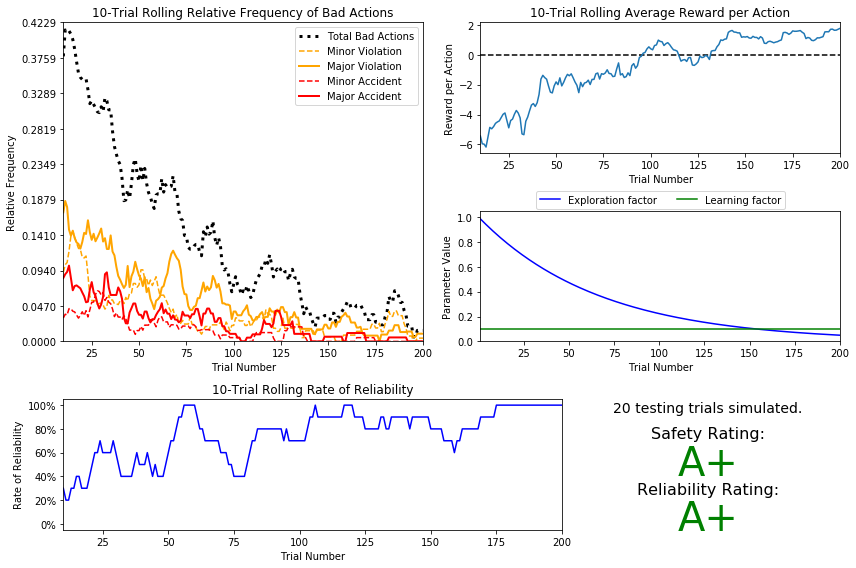

0.2 1 20 0.005


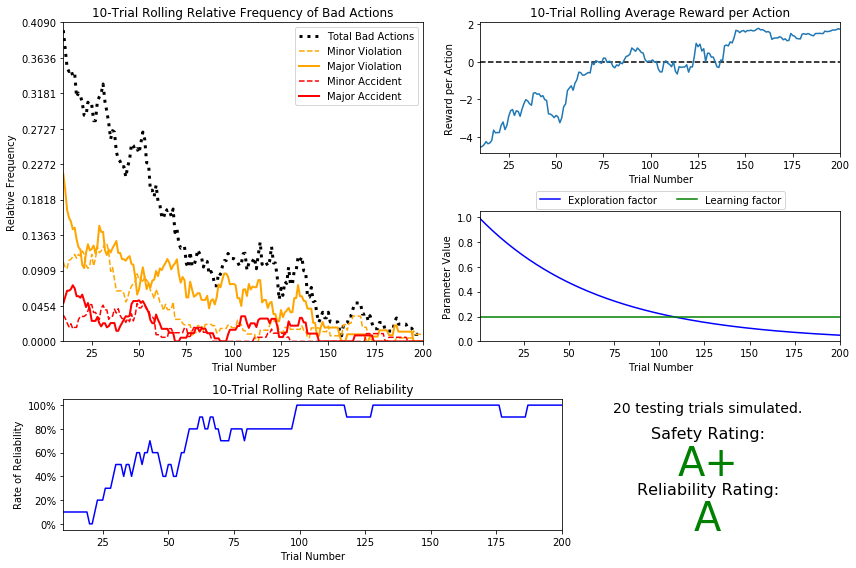

0.3 1 20 0.005


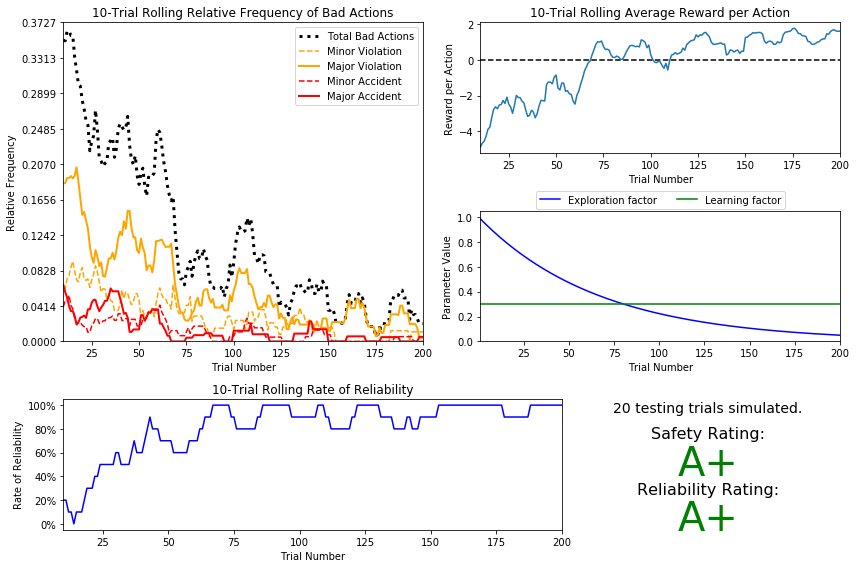

In [22]:
import subprocess
import numpy as np
# options = [[.5, 1, 100, 0.01], [.25, 1, 100, 0.0075], [.75, 1, 100, 0.005],
#           [0.25, 1, 50, 0.01], [0.25, 1, 50, 0.0075], [0.25, 1, 50, 0.005],
#           [0.75, 1, 50, 0.01], [0.75, 1, 50, 0.0075], [0.75, 1, 50, 0.005]]
for x in [0.1, 0.2, 0.3]:
    z = [x, 1, 20, 0.005]
    args = "{}".format(" ".join([str(i) for i in z]))
    print(args)
    subprocess.call('python smartcab/agent.py {}'.format(args))
    vs.plot_trials('sim_improved-learning.csv')

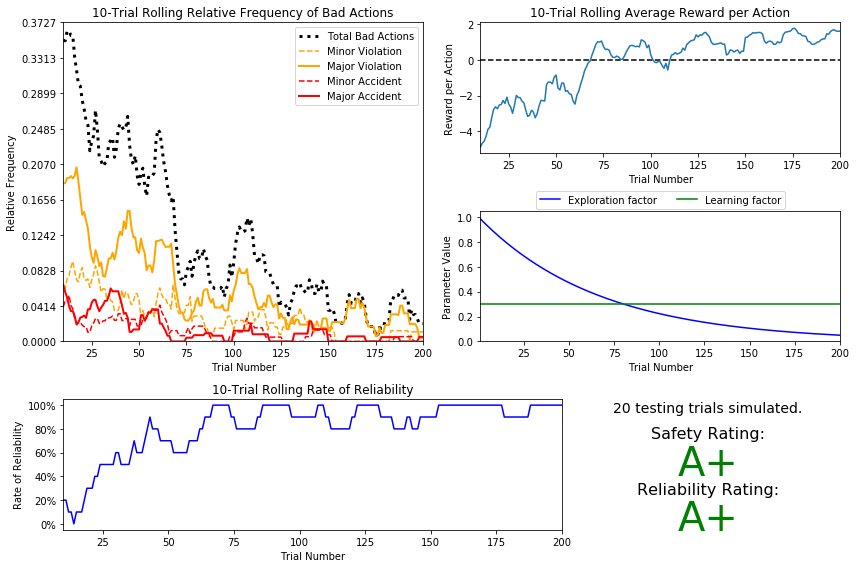

In [23]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**
- The selected decay function used for epsilon decay is $\epsilon = e^{-at}$, where ${a}$ is the constant term 0.015. This constant was experimentally found to faciliatate epsilon decay at a rate that produced an appropriate number of training trials allowing the Q-Learner to learn the optimal policies. Again, experiments showed that approximately 200 training trials seemed to be sufficient for the QLearner to learn the optimal policies.
- A linear decay function that reduced epsilon by 0.005 every step was also tested and yielded good results, but the $\epsilon = e^{-at}$ function appeared to perform slightly better over a number of tests than the linear decay function.
- The epsilon tolerance was kept fixed at 0.05. Rather than adjust the epsilon tolerance to reduce or increase the training trials, it seemed more straightforward to adjust the epsilon decay rate and keep the epsilon tolerance unchanged as it was already fairly low. Decreasing the value would only increase the training trials which could already be controlled by the decay rate parameters.
- After settling on an epsilon decay rate and function, various alpha learning rates were tested experimentally (starting at 0.1 and increasing in increments of 0.1) using a number of iterations where the other parameters were kept constant. The best alpha rates found for this driving simulation problem (using the chosen epsilon decay function and a target of ~200 training trails) was in the range (0.1 - 0.3). The best results were obtained with alpha equal to 0.3.
- This Q-Learner has greatly improved the safety rating, increasing from a 'D' to an 'A+'.
- Based on the improved results, it appears that on the whole (using a number of testing trials in the range of 10-50), that this Q-Learner has learned an appropriate set of policies for the problem domain and has produced optimal safety and reliability scores using the improved parameters.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.